In [1]:
from pykat import finesse        # import the whole pykat.finesse package
from pykat.commands import *     # import all packages in pykat.commands
import numpy as np               # for basic math/sci/array functions
import matplotlib.pyplot as plt  # for plotting
from PIL import Image

# tell the notebook to automatically show plots inline below each cell
%matplotlib inline               
# use pykat's plotting style. change dpi to change plot sizes on your screen
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.1.310         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [20]:
#finding center
def center(image,width,height):
    #constants
    Xb=0
    Yb=0
    Pixel_val=0
    Pixel_max=0
    
    even = False #even chck is for a two by two grid of values with a similar pixel value

    pix = image.load() #array of pixel values

    for x in range(width):
        for y in range(height):
            Pixel_val = pix[x,y]
            if Pixel_val > Pixel_max:
                Pixel_max = Pixel_val
                Xb = x
                Yb = y
                
    #center check (how?) assume always some square? necessary? 
    if(pix[Xb+1,Yb+1] == Pixel_max):
        even = True
    elif (pix[Xb+2,Yb+2] == Pixel_max): #if three by three center becmes center of some grid
        Xb+=1
        Yb+=1
        even = False
    
    if even:
        print ("even") #have not adjusted the masks for an even method, may be unnecessary
        
    location_val = (Xb,Yb,Pixel_max,even)
    #print (location_val)
    return location_val
    #add checks for multiple spots of similar brightness       

In [3]:
#finding waste size
#determine pixel size to determine true size not pixels from bright spot
def radius(Pixel_max,Xb,Yb,pix):
    #constants
    xbeam = int(.135 * Pixel_max) 
    #constant may need work, pixel value we are looking for 1/e^2 S.T. beam contains 85% power 
    #wiki said a standard is just the point that is .135 that of the maximum which is easier 
    #than calculating at what point th ebeam has 85% power  
    radius_pixel = Xb  #pixel where the beam "ends"

    for x in range(Xb):
        if pix[Xb-x,Yb] <= xbeam:
            radius_pixel = Xb - x
            #print (radius_pixel)
            break


    beam_size_pix = Xb - radius_pixel 
    #multiply by constant coresponding to length per pixel?
    #this is the size of the radius in pixel units
    
    if beam_size_pix == 0: 
        print ("Image is too close to the edge")

    return beam_size_pix

In [4]:
#method to sum retangular crops for masks
def sum(img,x1,x2,y1,y2):
    sum = 0 
  
    imageNew=img.crop((x1,y1,x2,y2))
    #imageNew.show() #if you want to make sure it is working
    
    pixels = list(imageNew.getdata())
    
    
    sum = np.sum(pixels) 
    
    return sum

In [5]:
#mask 1 L-R  ##changing to work with plots
def M1(pix,Xb,Yb,width,height,even): 
    
    #left
    Lx1 = 0
    Lx2 = Xb
    Ly1 = 0
    Ly2 = height - 1
    IL = sum(image,Lx1,Lx2,Ly1,Ly2)
    
    if even:
        Xrb = Xb + 1

    #right
    Lx1 = Xb
    Lx2 = width - 1
    Ly1 = 0
    Ly2 = height - 1
    IR = sum(image,Lx1,Lx2,Ly1,Ly2)
    
    #print (IL)
    #print (IR)
    #print (IL-IR)
    
    return IL - IR

In [6]:
#mask2 T-B
def M2(image,Xb,Yb,width,height,even):
    #top
    Lx1 = 0
    Lx2 = width - 1
    Ly1 = Yb
    Ly2 = height - 1
    IT = sum(image,Lx1,Lx2,Ly1,Ly2)

    if even:
        Ybb = Yb - 1
    #bottom
    Lx1 = 0
    Lx2 = width - 1
    Ly1 = 0
    Ly2 = Yb
    IB = sum(image,Lx1,Lx2,Ly1,Ly2)

    totalM2 = IT - IB
    #print (totalM2," ",IT," ",IB)
    return totalM2

In [7]:
#mask3 D1-D2
def M3(image,Xb,Yb,width,height,even):
    
    if even:
        Xrb = Xb +1 #Q1,Q4
        Ybb = Yb - 1 #Q3,Q4
            
    
    #Q1
    Lx1 = Xb
    Lx2 = width - 1
    Ly1 = Yb
    Ly2 = height - 1
    IQ1 = sum(image,Lx1,Lx2,Ly1,Ly2)

    #Q2
    Lx1 = 0
    Lx2 = Xb
    Ly1 = Yb
    Ly2 = height - 1
    IQ2 = sum(image,Lx1,Lx2,Ly1,Ly2)

    #Q3
    Lx1 = 0
    Lx2 = Xb
    Ly1 = 0
    Ly2 = Yb
    IQ3 = sum(image,Lx1,Lx2,Ly1,Ly2)

    #Q4
    Lx1 = Xb
    Lx2 = width - 1
    Ly1 = 0
    Ly2 = Yb
    IQ4 = sum(image,Lx1,Lx2,Ly1,Ly2)

    totalM3 = (IQ1 + IQ3) - (IQ2 + IQ4)
    #print (IQ1," ",IQ2," ",IQ3," ",IQ4," ")
    #print (IQ1 + IQ3," ",IQ2 + IQ4)
    #print (totalM3)
    return totalM3

In [8]:
#mask radius beam_size_pix, null_rad
def M4(image,null_rad,Xb,Yb,width,height,pix):
    #inner radius 
    I_inner = 0
    null_rad = int(null_rad) #fix this

    #inner circle, this is shit: fix it
    for y in range(2*null_rad+1):
         for x in range(2*null_rad+1):
            if ( ( ( (Xb - (Xb-null_rad+x) )**2) + ( (Yb - (Yb-null_rad+y) )**2) ) ** .5 <= null_rad): 
                I_inner += pix[Xb-null_rad+x,Yb-null_rad+y]
                
    

    #outer
    I_outer=0
    for a in range(width):
        for b in range(height):
            I_outer += pix[a,b]

    I_outer -= I_inner

    totalM4 = I_inner - I_outer
    print (totalM4," ",I_outer," ",I_inner)
    return totalM4

In [9]:
#creating image class, 
class image:
    
    def __init__(self,img):
        #constants
        self.width, self.height = img.size
        #imageCopy = img.copy()
        self.pix = img.load() #array of pixel values
        self.total = sum(img,0,0,self.width-1,self.height-1) #total pixel value
        
        #center
        self.brightSpot = center(img,self.width,self.height) #returns array (Xb,Yb,Val)
    
        #waist size
        self.w_Z = radius(self.brightSpot[2],self.brightSpot[0],self.brightSpot[1],self.pix) #beam size
        
        #null radius for bullseye mode. Pure bullseye should have 
        #equal amounts of power on each side of null radius
        self.null_rad = self.w_Z / (2**.5) 
        
        
        #cropped image for pixel count, is this the right place to do it?  
        #this is currently broken but i included it for the .crop method
        #only makes retangles, only thing it needs are four coordinates 
        
        #the bottom left and top right of the new image you wish to create
        #imageNew=imageCopy.crop((self.brightSpot[0]-self.w_Z,self.brightSpot[1]-self.w_Z,...
        #self.brightSpot[0]+self.w_Z,self.brightSpot[1]+self.w_Z))
        #self.newPix = imageNew.load() #this line creates 'NoneType' object is not subscriptable error in phase map
        
        
        #masks
        #M1
        self.M1=M1(img,self.brightSpot[0],self.brightSpot[1],self.width,self.height,self.brightSpot[3]) 
        
        #M1
        self.M2=M2(img,self.brightSpot[0],self.brightSpot[1],self.width,self.height,self.brightSpot[3]) 
        
        #M3
        self.M3=M3(img,self.brightSpot[0],self.brightSpot[1],self.width,self.height,self.brightSpot[3]) 
        
        #M4
        self.M4=M4(img,self.null_rad,self.brightSpot[0],self.brightSpot[1],self.width,self.height,self.pix)
        
        #image mask creation. ignore
        #method in artificial input pipeline, unsure how to change pixel values 
        #self.imgMask=mask_img(img,self.brightSpot[0],self.brightSpot[1],self.null_rad,self.width,self.height)

In [21]:
#screen shot image, save it, change file path to use created image
image1 = Image.open('Desktop/10a.png').convert('L') 
#UFPhaseCamera/Imagerun3/Het_test1_1.
#path to data run one
#.open('path to image') only for png images. This will need to be chaged if 
#you want to open images straight from the camera
image1.save('grayscale.png')
#image1.show() #opens on computer
Im1=image(image1)

#print (np.sum(Im1.pix))
#print (Im1.total)
#print (Im1.M1)
#print (Im1.M2)
#print (Im1.M3)

image2 = Image.open('Desktop/10b.png').convert('L')
image2.save('grayscale.png')
#image2.show() #opens on computer
Im2=image(image2)

image3 = Image.open('Desktop/10c.png').convert('L')
image3.save('grayscale.png')
#image3.show() #opens on computer
Im3=image(image3)

image4 = Image.open('Desktop/10d.png').convert('L')
image4.save('grayscale.png')
#image4.show() #opens on computer
Im4=image(image4)


even
-137165   608352   471187
even
713180   182096   895276
even
105710   487402   593112
even
-373140   725266   352126


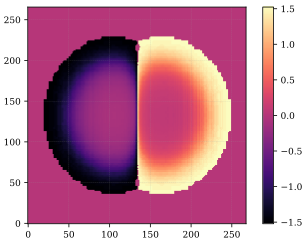

In [14]:
#phase of each pixel, assuming: four images read in, equally centered and sized
from numpy import empty

x = Im1.width
y=Im1.height
phase = empty([Im1.height ,Im1.width])

#this block is good for auto genreated images because the fourth and second image are identical
#this prevents an solid image throughout, should still be a good representation of the phase
for a in range(x-2):
    for b in range(y-2):
        Im4.pix[a,b] += 10

        
#it seems that for the .pix coordinate system that second coordinate is the y 
#where as for the phase array the y is in the first
#also because why should anything ever be easy (0,0) is the top left for the .pix and 
#(0,0) is the bottom left for the phase array (thus the y-1-a for the y coordinate)
for b in range(x):     
    for a in range(y):
        if (Im1.pix[b,a] - Im3.pix[b,a]) == 0:
            phase[y-1-a,b]=0
        else:
            phase[y-1-a,b]=np.arctan( (Im4.pix[b, a] - Im2.pix[b , a ]) / (Im1.pix[b , a] - Im3.pix[b, a]) )
        
#plt.pcolormesh(x,y,phase)       
plt.imshow(phase)
plt.colorbar()
plt.show()


#why did I have to switch b and a ?????

In [15]:
#avergage power
def avg_int (im1,im2,im3,im4):
    x=Im1.width
    y=int(Im1.height)
    
    avg_int = empty([y,x])
    
    for a in range(x):
        for b in range(y):
            avg_int[b,a] = ((im1[a,b] + im2[a,b] + im3[a,b] + im4[a,b]) / 4)**.5 #sqrt of average
            
    return avg_int

In [16]:
#+-1 phase
x=Im1.width
y=int(Im1.height)

phase_val = empty([y,x])

for a in range(x):
    for b in range (y):
        if phase[b,a] == 0:
            phase_val[b,a] = 0
        elif phase[b,a] <0:
            phase_val[b,a] = -1
        else: 
            phase_val[b,a] = 1
            

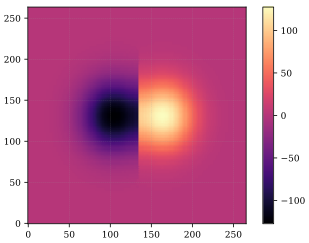

-530452.5
533153.75
132
266
1312.75
1388.5


-75.75

In [63]:
#creating array to add phase to intensity plot (phase should be + or - 1??) 
#efield plot represents some proportonal plot to actual efield
x=int(Im1.width-2)
y=int(Im1.height-2)

e_field = empty([y,x])

#multiply phase onto (average?) intensity
for b in range(x):
    for a in range(y):
        e_field[y-1-a,b] = phase_val[y-1-a,b] * ( (Im1.pix[b,a] + Im2.pix[b,a] + Im3.pix[b,a] + Im4.pix[b,a]) / 4)
        

        
plt.imshow(e_field)
plt.colorbar()
plt.show()
    
    
mask1(e_field,x,y)
mask2(e_field,x,y)

In [23]:
##masks for Efield and phase plots
##some are for higer modes

In [50]:
#L-R 
#phase map should have some two distinct regions of positive and negative if any 1,0 
#mode is in the interference patern 
def mask1 (plot, plot_W, plot_H): 
    
    #find where plot shifts 
    X_coord=int(plot_W/2)
    past_val=0
    new_val=0
    some_Y=int(plot_H/2)
    for i in range(plot_W-5):
        past_val=plot[some_Y,i]
        new_val=plot[some_Y,i+1]
        if (past_val < 0 and new_val > 0) or (past_val > 0 and new_val < 0): #if HG10 mode 
            X_coord=i
            break
          
        
    #section plots
    plotL=empty([plot_H,X_coord])
    plotR=empty([plot_H,plot_W-X_coord])
    
    #filling plots
    for a in range(plot_H):
        for b in range(X_coord):
            plotL[a,b]=plot[a,b]
        for c in range (plot_W-X_coord):
            plotR[a,c]=plot[a,X_coord+c]
    
    #summing plots
    sumL=np.sum(plotL)
    sumR=np.sum(plotR)
    
    print (sumL)
    print (sumR)
    return sumL-sumR

In [62]:
#T-B
#if any 0,1 order mode has been excited
def mask2 (plot, plot_W, plot_H):
    #find where plot shifts 
    Y_coord=int(plot_H/2) #incase there is no misalignment
    #Need figure out how to set brightspot and change only if +- phase map
    
    past_val=0
    new_val=0
    some_X=int(plot_W/2)
    
    for i in range(plot_H-5):
        past_val=plot[i,some_X]
        new_val=plot[i+1,some_X]
        if (past_val < 0 and new_val > 0) or (past_val > 0 and new_val < 0): #if HG10 mode 
            Y_coord=i
            break
            
    #section plots
    plotT=empty([plot_H-Y_coord,plot_W])
    plotB=empty([Y_coord,plot_W])
    
    
    #filling plots
    for a in range(plot_W):
        for b in range(plot_H-Y_coord):
            plotT[b,a]=plot[b+Y_coord,a]
        for c in range (Y_coord):
            plotB[c,a]=plot[c,a]
            
            
    #summing plots
    sumT=np.sum(plotT)
    sumB=np.sum(plotB)
    
    print (sumT)
    print (sumB)
    return sumT-sumB
    